In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pickle

from gpmap.utils import hamming_distance
from collections import Counter
import networkx as nx
from networkx.readwrite import json_graph

In [42]:
with open("two-state-predictions/results/double-mutant-4-hamming.pickle", "rb") as f:
    a = pickle.load(f)
    pos_hamming = a[0]
    neg_hamming = a[1]

In [43]:
pos_hamming = ma.masked_invalid(pos_hamming)
neg_hamming = ma.masked_invalid(neg_hamming)

(array([  288.,  1899.,     0.,     0.,     0.,     0.,     0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 <a list of 7 Patch objects>)

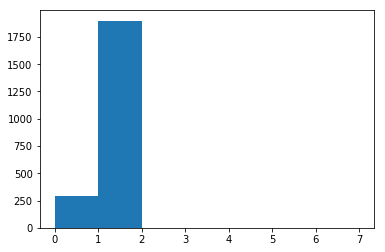

In [44]:
plt.hist(pos_hamming[:,5], bins=7, range=(0,7))

(array([ 2187.,     0.,     0.,     0.,     0.,     0.,     0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 <a list of 7 Patch objects>)

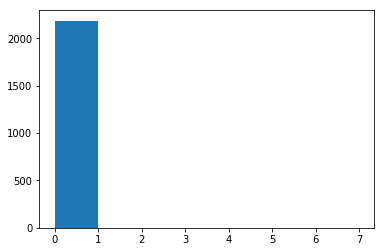

In [45]:
plt.hist(neg_hamming[:,4], bins=7, range=(0,7))

In [14]:
with open("two-state-predictions/results/.pickle", "rb") as f:
    a = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'two-state-predictions/results/.pickle'

In [44]:
def make_json(hamming):
    import json

    G = nx.DiGraph()
    mutations = range(0,7)
    for n in mutations:
        edges = Counter(zip(hamming[:,n], hamming[:,n+1]))
        for key, val in edges.items():
            G.add_edge((n, key[0]), (n+1, key[1]), value=val)
    x = json_graph.node_link_data(G)
    for item in x["nodes"]:
        val = item["id"] 
        new = (int(val[0]),int(val[1]))
        item["id"] = new

    return json.dumps(x)

In [7]:
make_json(pos_hamming)

'{"directed": true, "nodes": [{"id": [2, 0]}, {"id": [0, 0]}, {"id": [7, 0]}, {"id": [5, 0]}, {"id": [3, 0]}, {"id": [1, 0]}, {"id": [6, 0]}, {"id": [4, 0]}], "links": [{"value": 2187, "source": 0, "target": 4}, {"value": 2187, "source": 1, "target": 5}, {"value": 2187, "source": 3, "target": 6}, {"value": 2187, "source": 4, "target": 7}, {"value": 2187, "source": 5, "target": 0}, {"value": 2187, "source": 6, "target": 2}, {"value": 2187, "source": 7, "target": 3}], "multigraph": false, "graph": {}}'

In [8]:
make_json(neg_hamming)

'{"directed": true, "nodes": [{"id": [6, 4]}, {"id": [0, 0]}, {"id": [7, 1]}, {"id": [3, 0]}, {"id": [6, 0]}, {"id": [6, 2]}, {"id": [5, 1]}, {"id": [4, 0]}, {"id": [4, 2]}, {"id": [1, 0]}, {"id": [7, 2]}, {"id": [5, 3]}, {"id": [7, 4]}, {"id": [7, 0]}, {"id": [4, 1]}, {"id": [6, 1]}, {"id": [3, 1]}, {"id": [6, 3]}, {"id": [2, 0]}, {"id": [7, 5]}, {"id": [5, 0]}, {"id": [7, 3]}, {"id": [5, 2]}], "links": [{"value": 16, "source": 0, "target": 12}, {"value": 2, "source": 0, "target": 19}, {"value": 2187, "source": 1, "target": 9}, {"value": 216, "source": 3, "target": 14}, {"value": 1809, "source": 3, "target": 7}, {"value": 1341, "source": 4, "target": 13}, {"value": 114, "source": 4, "target": 2}, {"value": 148, "source": 5, "target": 21}, {"value": 74, "source": 5, "target": 10}, {"value": 186, "source": 6, "target": 15}, {"value": 165, "source": 6, "target": 5}, {"value": 198, "source": 7, "target": 6}, {"value": 1611, "source": 7, "target": 20}, {"value": 27, "source": 8, "target": 

In [9]:
%load_ext py_d3

ImportError: No module named 'py_d3'

In [ ]:

neg_hamming = np.zeros((len(a), 5), dtype=float)
for mut in range(5):
    index = 3 ** 7 / 3 ** mut
    subslice = index * np.arange(3**mut)
    subslice = subslice.astype(int)
    for index, i in enumerate(subslice[:-1]):
        try:
            seq1 = a[i, mut]
            print(i)
            hd = [hamming_distance(seq1, p[position][mut]) for position in subslice]
            try:
                neg_hamming[subslice[index]:subslice[index+1], mut] = min(hd)
            except IndexError:
                neg_hamming[subslice[index]:subslice[index+1], mut] = np.inf
        except IndexError:
            neg_hamming[subslice[index]:subslice[index+1], mut] = np.nan
            
            
            
z = """
neg_hamming = np.zeros((len(p), 8), dtype=float)
for mut in range(8):
    for i, path in enumerate(a):
        try:
            seq1 = path[mut]
            index = 3 ** 7 / 3 ** mut
            subslice = index * np.arange(3**mut)
            subslice = subslice.astype(int)
            hd = []
            for j, position in enumerate(subslice):
                try:
                    seq2 = p[position][mut]
                    hd.append(hamming_distance(seq1, seq2))
                    neg_hamming[i, mut] = min(hd)
                except IndexError:
                    neg_hamming[i, mut] = np.inf
        except IndexError:
            neg_hamming[i, mut] = np.nan
"""

In [62]:
import numpy as np
import itertools as it

from latticeproteins.thermodynamics import LatticeThermodynamics
from latticeproteins.interactions import miyazawa_jernigan
from latticeproteins.conformations import Conformations, ConformationList
from latticeproteins.sequences import find_differences, _residues

In [63]:
class PredictedLattice(object):
    """Lattice model predictor using epistasis.
    """
    def __init__(self, wildtype, temp, confs, target=None):
        self.wildtype = wildtype
        self.temp = temp
        self.conformations = confs
        self.target = target
        self._lattice = LatticeThermodynamics(self.temp, self.conformations)

        combos = []
        sites = list(range(self.conformations.length()))
        self.dG0 = self._lattice.stability(self.wildtype, target=self.target)

        # Calculate first order coefs
        self.dGs = {}
        for i in sites:
            other_sites = sites[:]
            other_sites.remove(i)
            for aa in _residues:
                combos.append((i, aa))

        for c in combos:
            seq = list(self.wildtype[:])
            seq[c[0]] = c[1]
            self.dGs[c] = self._lattice.stability(seq, target=self.target) - self.dG0

        # Calculate second order coefs
        combos = []
        sites = list(range(self.conformations.length()))
        for i in sites:
            other_sites = sites[:]
            other_sites.remove(i)
            for aa in _residues:
                for j in other_sites:
                    for aa2 in _residues:
                        combos.append((i,aa,j,aa2))

        for c in combos:
            seq = list(self.wildtype[:])
            seq[c[0]] = c[1]
            seq[c[2]] = c[3]
            # Calculate dG2
            self.dGs[c] = self._lattice.stability(seq, target=self.target) - (self.dG0 + self.dGs[(c[0],c[1])] + self.dGs[(c[2],c[3])])

    def stability(self, seq, target=None):
        # Get additive coefs to build predictions
        if target != self.target:
            raise Exception("Target does not match wildtype target.")
        loci = find_differences(self.wildtype, seq)
        add = [(pair[0], seq[pair[0]]) for pair in it.combinations(loci, 1)]
        pairs = [(pair[0], seq[pair[0]], pair[1], seq[pair[1]]) for pair in it.combinations(loci, 2)]
        dgs = add + pairs
        stability = float(self.dG0)
        for coef in dgs:
            stability += self.dGs[coef]
        return stability

In [64]:
wt =  "HWEMHEKWEM"
seq = "FLWEMGLWEL"
temp = 1
target = None

length = len(seq)
# Build the conformation database
full_confs = Conformations(length, "database")
# Top 20 conformations
top_confs = full_confs.k_lowest_confs(seq, temp, 20)
# Choose random confs from this list
landscape = np.random.choice(top_confs[:19], size=1)
# Build a new conformation database from this list
if target is None:
    target = top_confs[-1]
landscape = np.concatenate((top_confs, [target]))
confs = ConformationList(length, landscape)

l = PredictedLattice(wt, 1, confs)

In [67]:
l.stability(seq)

11.174514650631522

In [69]:
loci = find_differences(wt, seq)
print(loci)
add = [(pair[0], seq[pair[0]]) for pair in it.combinations(loci, 1)]
pairs = [(pair[0], seq[pair[0]], pair[1], seq[pair[1]]) for pair in it.combinations(loci, 2)]
dgs = add + pairs
print(dgs)

[0, 1, 2, 3, 4, 5, 6, 9]
[(0, 'F'), (1, 'L'), (2, 'W'), (3, 'E'), (4, 'M'), (5, 'G'), (6, 'L'), (9, 'L'), (0, 'F', 1, 'L'), (0, 'F', 2, 'W'), (0, 'F', 3, 'E'), (0, 'F', 4, 'M'), (0, 'F', 5, 'G'), (0, 'F', 6, 'L'), (0, 'F', 9, 'L'), (1, 'L', 2, 'W'), (1, 'L', 3, 'E'), (1, 'L', 4, 'M'), (1, 'L', 5, 'G'), (1, 'L', 6, 'L'), (1, 'L', 9, 'L'), (2, 'W', 3, 'E'), (2, 'W', 4, 'M'), (2, 'W', 5, 'G'), (2, 'W', 6, 'L'), (2, 'W', 9, 'L'), (3, 'E', 4, 'M'), (3, 'E', 5, 'G'), (3, 'E', 6, 'L'), (3, 'E', 9, 'L'), (4, 'M', 5, 'G'), (4, 'M', 6, 'L'), (4, 'M', 9, 'L'), (5, 'G', 6, 'L'), (5, 'G', 9, 'L'), (6, 'L', 9, 'L')]


In [70]:
    add = [(pair[0], seq[pair[0]]) for pair in it.combinations(loci, 1)]
    pairs = [(pair[0], seq[pair[0]], pair[1], seq[pair[1]]) for pair in it.combinations(loci, 2)]
    dgs = add + pairs

In [71]:
l.dG0

1.4979425176274415

In [44]:
a

[array([[ 0.,  1.,  1., ...,  1.,  1.,  1.],
        [ 0.,  1.,  1., ...,  1.,  1.,  0.],
        [ 0.,  1.,  1., ...,  1.,  1.,  1.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  2.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]])]

In [46]:
with open("two-state-predictions/results/double-mutant-walks-7-3.pickle", "rb") as f:
    out = pickle.load(f)
    a, dG = out[0], out[1] # = pickle.load()